# Measure the radial velocity
This notebook interfaces with the Measure_RV.py code to measure the radial velocity of some stars. It uses the RVFitter class to do an MCMC fit.

In [1]:
import Measure_RV
import matplotlib.pyplot as plt
import logging
import triangle
import numpy as np
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.
rv/:
 continpars@    fxcor           rvcorrect       rvreidlines
 filtpars@      keywpars@       rvidlines


:0: FutureWarning: IPython widgets are experimental and may change in the future.


INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): simbak.cfa.harvard.edu


7200
/media/ExtraSpace/PhoenixGrid/CHIRON_Grid.hdf5


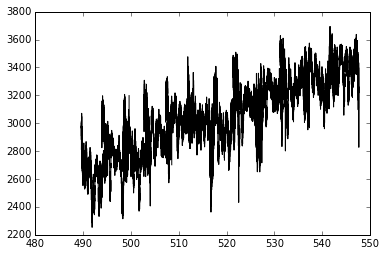

In [2]:
reload(Measure_RV)
fitter = Measure_RV.make_fitter('20140208/HIP_69475.fits')
for xi, yi in zip(fitter.x, fitter.y):
    plt.plot(xi, yi, 'k-')

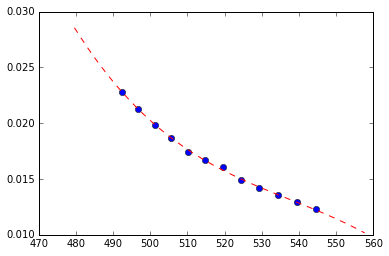

[47.657005384314374, 167.36877683348956, 0.5, 3569.5474382512875, 7200]


In [13]:
initial_pars = fitter.guess_fit_parameters()
#initial_pars = np.array([-7., 18., 0., 3220., 11850.])
print(initial_pars)

In [3]:
model_orders = fitter.model(initial_pars, fitter.x)
scale_factor = fitter._fit_factor(fitter.x, model_orders, fitter.y)
print(scale_factor)
#%prun fitter._fit_factor(fitter.x, model_orders, fitter.y)

NameError: name 'initial_pars' is not defined

In [8]:
%prun fitter._lnlike(initial_pars)

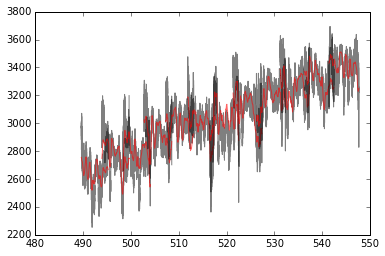

In [16]:
orders = Measure_RV.HelperFunctions.ReadExtensionFits('20140208/HIP_50847.fits')

for xi, yi, model, f in zip(fitter.x, fitter.y, model_orders, scale_factor):
    
    plt.plot(xi, yi, 'k-', alpha=0.5)
    plt.plot(xi, model*f, 'r-', alpha=0.6)
plt.show()

In [3]:
#fitter.fit(nwalkers=100, n_burn=100, n_prod=200, guess=False, initial_pars=initial_pars)
fitter.fit(n_live_points=1500, basename='RVFitter/single-', overwrite=True)

/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1424: UserWarning: vsini too small (19543.170929). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1424: UserWarning: vsini too small (69785.118103). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1424: UserWarning: vsini too small (44851.3031006). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1424: UserWarning: vsini too small (21302.7000427). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1424: UserWarning: vsini too small (44798.8510132). Not broadening!
  linear=True, findcont=False)


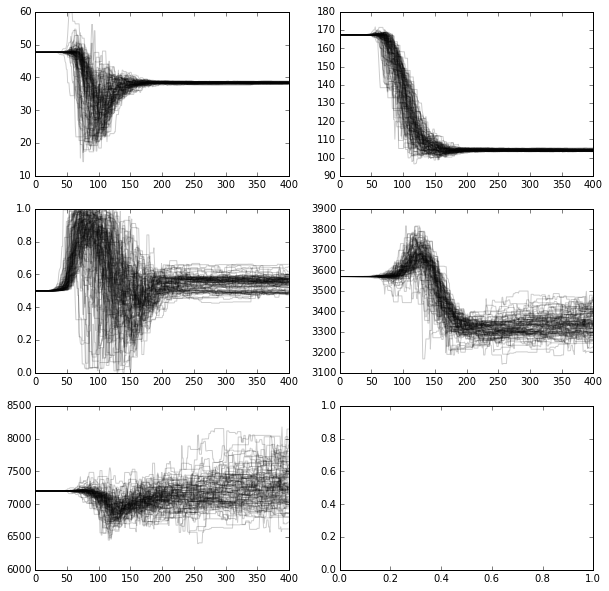

In [18]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))
axes = axes.flatten()
for i in range(fitter.sampler.chain.shape[-1]):
    ax = axes[i]
    _ = ax.plot(fitter.sampler.chain[:, :, i].T, 'k-', alpha=0.2)
#_ = plt.plot(fitter.sampler.chain[:, :, 0].T, 'k-', alpha=0.2)#

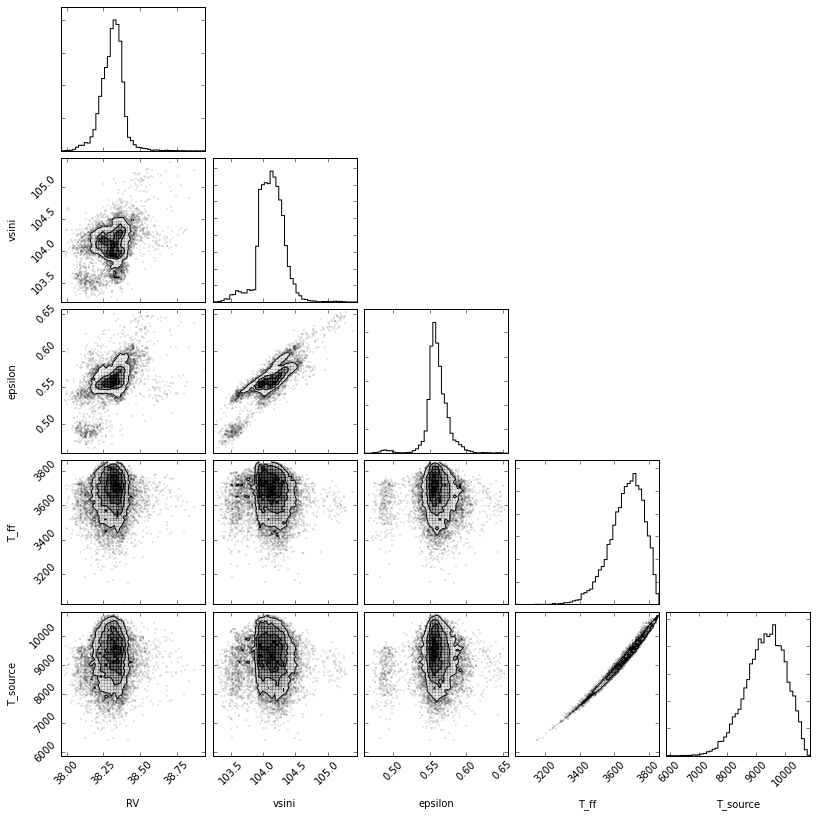

In [4]:

#samples = fitter.sampler.chain[:, 200:, :].reshape((-1, fitter.sampler.chain.shape[-1]))
#triangle.corner(samples)
fitter.triangle()

<IPython.core.display.Javascript object>


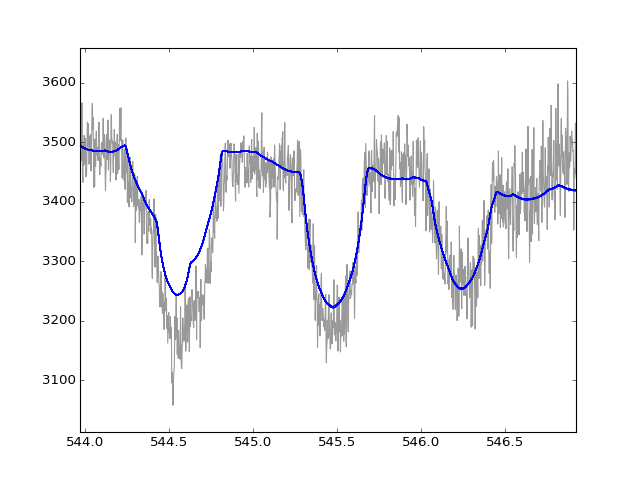

In [5]:
%matplotlib notebook
fitter.plot(alpha=0.4)

In [7]:
fitter.samples.RV.mean(), fitter.samples.RV.std()

(38.309386444615413, 0.077107312192636737)

In [38]:
print(initial_pars)

[-13.235058325012394, 41.029072653035556, 0.5, 3304.2710854903576, 12000, -3.6150115895134648e-08, 5.798360480257152e-05, -0.031083264405581065, 5.5766214643256911]
